In [91]:
import croissant as cro

from astropy.units import K as Kelvin, s as seconds
import healpy
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

In spherical coordinates, where $\theta$ is the polar angle, the power of a dipole antenna is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In [92]:
# 1 deg spacing, must be radians
theta = np.linspace(0, np.pi, num=181)
theta.shape = (1, -1, 1)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)
freq.shape = (-1, 1, 1)
# dipole beam
power = freq**2 * np.cos(theta)**2
power = np.repeat(power, phi.size, axis=-1)

In [93]:
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq, coords="topocentric")

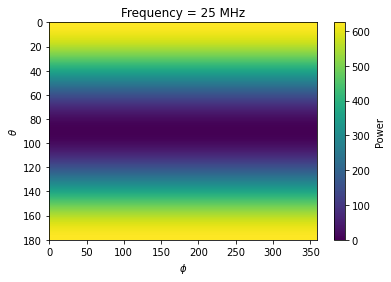

In [94]:
plot_freq = 25  # MHz
freq_ix = np.argmin(np.abs(beam.frequencies-plot_freq))
ex = [beam.phi.min(), beam.phi.max(), beam.theta.max(), beam.theta.min()]
ex_deg = [np.rad2deg(bd) for bd in ex]
plt.figure()
plt.imshow(beam.data[freq_ix], aspect="auto", extent=ex_deg)
plt.colorbar(label="Power")
plt.title(f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz")
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.show()

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [95]:
sky = cro.sky.Sky.gsm(beam.frequencies, power_law=True, gen_freq=25, spectral_index=-2.5)

In [96]:
lmax = 128
loc = (90., 0., 0.)
t_start = Time("2022-06-01 23:09:16")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=False, lmax=lmax
)

In [97]:
# force m!=0 modes to be 0 (since the beam should have azimuthal symmetry)
#sim.beam.alm[:, sim.lmax+1:] = 0  

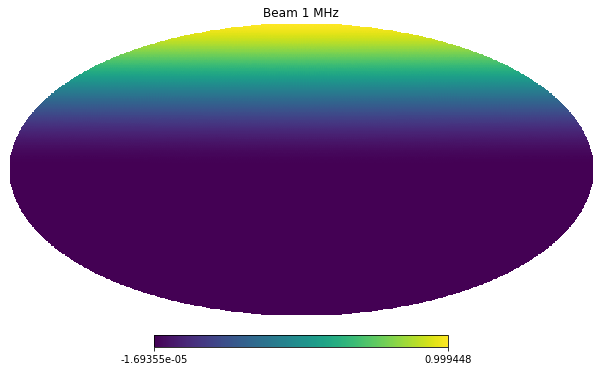

In [98]:
# the beam as seen by the simulator after horizon cutoff and converting to Alm
healpy.mollview(cro.healpix.alm2map(sim.beam.alm)[0], title="Beam 1 MHz")

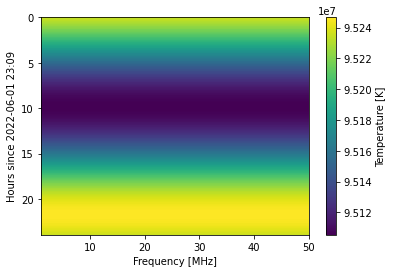

In [99]:
sim.run(dpss=False)
sim.waterfall *= sim.beam.total_power / (sim.beam.compute_total_power())  # account for horizon cutoff...
sim.plot(power=2.5)

In [100]:
from pyuvsim import simsetup
t_arr = sim.t_start + sim.dt * seconds
uvd = simsetup.initialize_uvdata_from_keywords(
    array_layout={0: [0,0,0]},
    telescope_location=loc,
    telescope_name="croissant",
    freq_array=sim.frequencies*1e6,
    time_array=t_arr.to_value("jd"),
    bls=[(0,0)],
    complete=True,
    write_files=False,
)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


In [102]:
# sky model
from pyradiosky import SkyModel

hpx_inds = np.arange(sky.npix)
stokes = np.zeros((4, 1, sky.npix)) * Kelvin
stokes[0, :, :] = healpy.Rotator(coord="gc").rotate_map_alms(sky.data[0]) * Kelvin  # in equatorial

diffuse_params = {
    'component_type': "healpix",
    'nside': sky.nside,
    'hpx_inds': hpx_inds,
    'hpx_order': "ring",
    'spectral_type': "spectral_index",
    'reference_frequency': np.full(sky.npix, sim.frequencies[0]*1e6),  # must be in Hz
    'spectral_index': np.full(sky.npix, -2.5),
    'stokes': stokes,
    'frame': "icrs"
}
diffuse_model = SkyModel(**diffuse_params)

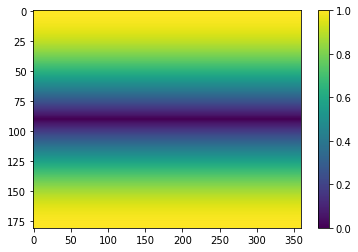

In [103]:
# beam
from pyuvsim import AnalyticBeam
import pyuvdata.utils as uvutils

class DipoleBeam(AnalyticBeam):
    """
    Most code is taken from pyuvsim/analyticbeam.py written by the RadioAstronomySoftwareGroup.
    This is to get the right format for HERA_sim to read.
    """
    def __init__(self):
        self.type = "dipole"
        
        # default AnalyticBeam params:
        self.sigma = None
        self.ref_freq = 1.0
        self.spectral_index = 0.0
        self.diameter = None
        self.data_normalization = "peak"
        self.freq_interp_kind = "linear"
        self.beam_type = "efield"
        
    def interp(self, az_array, za_array, freq_array, **kwargs):         
        interp_data = np.zeros((2, 1, 2, freq_array.size, az_array.size), dtype=float)
        # since this is efield, we make it the square root of the dipole power
        interp_data[0, 0, 0] = np.abs(freq_array[:, None]/1e6 * np.cos(za_array[None, :]))
        interp_data[0, 0, 1] = np.abs(freq_array[:, None]/1e6 * np.cos(za_array[None, :]))
        
        values = interp_data[0, 0, 0]
        interp_basis_vector = None
        
        if self.beam_type == 'power':
            # Cross-multiplying feeds, adding vector components
            pairs = [(i, j) for i in range(2) for j in range(2)]
            power_data = np.zeros((1, 1, 4) + values.shape, dtype=float)
            for pol_i, pair in enumerate(pairs):
                power_data[:, :, pol_i] = (
                    (interp_data[0, :, pair[0]] * np.conj(interp_data[0, :, pair[1]]))
                    + (interp_data[1, :, pair[0]] * np.conj(interp_data[1, :, pair[1]]))
                )
            interp_data = power_data
        return interp_data, interp_basis_vector
    
    def __eq__(self, other):
        """
        Overwrite the __eq__ method of AnalyticBeam.
        """
        if not isinstance(other, self.__class__):
            return False
        else:
            return other.type == 'dipole'


dipole = DipoleBeam()
p, t = [x.ravel() for x in np.meshgrid(sim.beam.phi, sim.beam.theta)]
dipole_data = dipole.interp(p, t, sim.frequencies*1e6)[0][0, 0, 0]
dipole_data.shape = (-1, sim.beam.theta.size, sim.beam.phi.size)

plt.figure()
plt.imshow(dipole_data[0], aspect="auto")
plt.colorbar()
plt.show()

In [104]:
np.allclose(dipole_data**2, beam.data)

True

# VisCPU

In [105]:
from copy import deepcopy
from hera_sim.visibilities import ModelData
data_model = ModelData(
    uvdata=deepcopy(uvd),
    sky_model=deepcopy(diffuse_model),
    beam_ids=[0],
    beams=[deepcopy(dipole)],
    normalize_beams=False,
)

In [106]:
from hera_sim.visibilities import VisCPU, VisibilitySimulation
t_mid = sim.t_start + 1/2 * sim.dt[-1] * seconds
vis_class = VisCPU(use_pixel_beams=False, precision=1, ref_time=t_mid, correct_source_positions=True)
vis_cpu = VisibilitySimulation(deepcopy(data_model), vis_class, sky.nside)
_ = vis_cpu.simulate()

In [109]:
jy2k = sky.data[:, 0] / vis_cpu.data_model.sky_model.stokes[0, :, 0].value  # jansky to K conversion
vis_wfall = vis_cpu.data_model.uvdata.get_data((0, 0, "xx")).real.copy()
vis_wfall *= jy2k  # jy to K
vis_wfall *= 2  # 2 pols
vis_wfall *= 4*np.pi / sky.npix  # surface area of each pixel
vis_wfall /= (2*np.pi/3 * sim.frequencies**2)  # normalization by total beam power

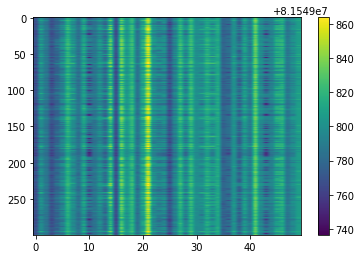

In [111]:
plt.figure()
plt.imshow(vis_wfall * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

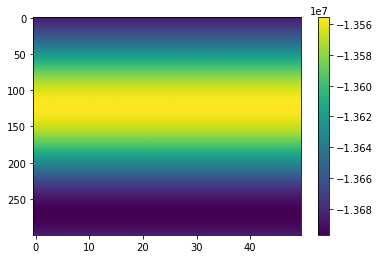

In [112]:
plt.figure()
plt.imshow((vis_wfall - sim.waterfall) * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

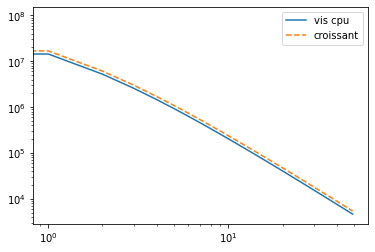

In [113]:
plt.figure()
plt.plot(vis_wfall[0], label="vis cpu")
plt.plot(sim.waterfall[0], ls="--", label="croissant")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

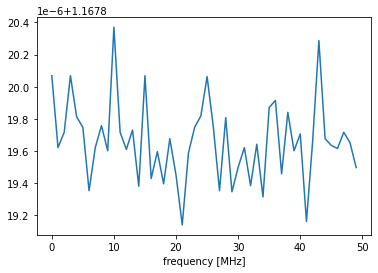

In [114]:
plt.figure()
plt.plot(sim.waterfall[0] / vis_wfall[0])
plt.xlabel("frequency [MHz]")
plt.show()

# pyuvsim

In [123]:
from hera_sim.visibilities import UVSim

uvsim = VisibilitySimulation(deepcopy(data_model), UVSim(), sky.nside)
_ = uvsim.simulate()

Nbls: 1
Ntimes: 300
Nfreqs: 50
Nsrcs: 49152
Tasks:  15000.0


UVSim requires time-ordered data. Ensuring that order in UVData...


1.00% completed. 0:00:02.658614  elapsed. 0:04:23.202778 remaining. 

2.00% completed. 0:00:05.012913  elapsed. 0:04:05.632760 remaining. 

3.00% completed. 0:00:07.461859  elapsed. 0:04:01.266782 remaining. 

4.00% completed. 0:00:09.997523  elapsed. 0:03:59.940554 remaining. 

5.00% completed. 0:00:12.670411  elapsed. 0:04:00.737811 remaining. 

6.00% completed. 0:00:16.244273  elapsed. 0:04:14.493606 remaining. 

7.00% completed. 0:00:19.795349  elapsed. 0:04:22.995353 remaining. 

8.00% completed. 0:00:23.384304  elapsed. 0:04:28.919497 remaining. 

9.00% completed. 0:00:26.906300  elapsed. 0:04:32.052587 remaining. 

10.00% completed. 0:00:30.393095  elapsed. 0:04:33.537851 remaining. 

11.00% completed. 0:00:33.884048  elapsed. 0:04:34.152756 remaining. 

12.00% completed. 0:00:37.569471  elapsed. 0:04:35.509457 remaining. 

13.00% completed. 0:00:41.104845  elapsed. 0:04:35.086271 remaining. 

14.00% completed. 0:00:44.701701  elapsed. 0:04:34.596164 remaining. 

15.00% complete

In [124]:
uvsim_wfall = uvsim.data_model.uvdata.get_data((0, 0, "xx")).real.copy()
uvsim_wfall *= jy2k  # jy to K
uvsim_wfall *= 2  # 2 pols
uvsim_wfall *= 4*np.pi / sky.npix  # surface area of each pixel
uvsim_wfall /= (2*np.pi/3 * sim.frequencies**2)  # normalization by total beam power

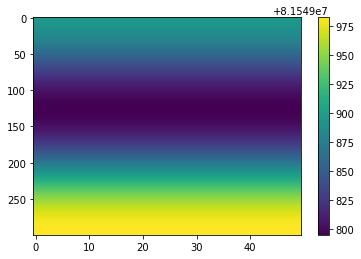

In [125]:
plt.figure()
plt.imshow(uvsim_wfall * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

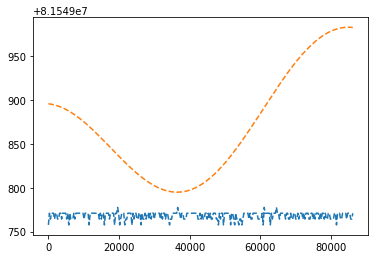

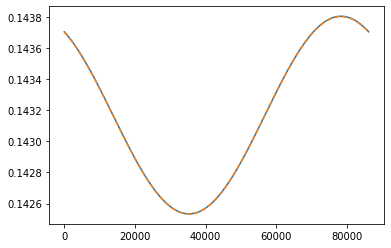

In [149]:
plt.figure()
#plt.plot(sim.dt, sim.waterfall[:, 0])
plt.plot(sim.dt, vis_wfall[:, 0], ls="--")
plt.plot(sim.dt, uvsim_wfall[:, 0], ls="--")
plt.show()

plt.figure()
plt.plot(sim.dt, (sim.waterfall[:, 0] - vis_wfall[:, 0])/sim.waterfall[:, 0])
plt.plot(sim.dt, (sim.waterfall[:, 0] - uvsim_wfall[:, 0])/sim.waterfall[:, 0], ls="--")
plt.show()

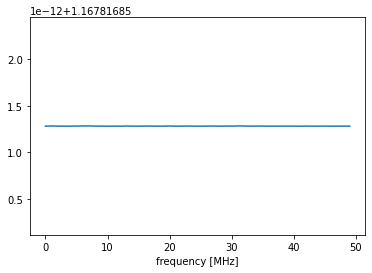

In [150]:
plt.figure()
plt.plot(sim.waterfall[-1] / uvsim_wfall[-1])
plt.xlabel("frequency [MHz]")
plt.show()